## The Investigation of the Fandango Movie Ratings

### Introduction

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest ([Fandango](https://www.fandango.com/) is an online movie ratings aggregator). He published his analysis [in this article](He published his analysis).

Fandango's officials replied that the biased rounding off was caused by a bug in their system rather than being intentional, and they promised to fix the bug as soon as possible. Presumably, this has already happened, although we can't tell for sure since the actual rating value doesn't seem to be displayed anymore in the pages' HTML.

### Is Fandango Still Inflating Ratings?

In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

### Understanding the data

In [43]:
import pandas as pd
pd.options.display.max_columns = 100 #limiting displayed output

pre_article = pd.read_csv('fandango_score_comparison.csv')
post_article = pd.read_csv('movie_ratings_16_17.csv')

pre_article.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,1.10,2.35,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,1.45,1.70,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [44]:
post_article.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


Bellow, we isolate only the columns that provide Fandango ratings information so we have the data we are interested in.

In [45]:
fandango_pre = pre_article[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
fandango_post = post_article[['movie', 'year', 'fandango']].copy()

fandango_pre.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [46]:
fandango_post.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


Because we want to find out whether the parameters of the population have changed after the Hickey's investigation, we are interested in sampling from two periods of time - before and after the investigation - so we can compare the two sets.

We want to describe the population, so we need to make sure the samples are representative, otherwise, we should expect big sampling error and false conclusions.

From Hickey's article and from README.md on [data set repository](https://github.com/fivethirtyeight/data/tree/master/fandango), for sampling the data were used the following criteria:
- the movies must have had at least 30 fan ratings on the Fandango website at the time of sampling.
- the movies must have had tickets on sale in 2015.

The sampling was clearly not objective because not all the movies had the chance to be included, like those with the number of ratings lower than 30. Furthermore, movies from 2015 might have been outstandingly good or bad compared to other years.

The sampling criteria for our other dataset, as described in [dataset repository](https://github.com/mircealex/Movie_ratings_2016_17):
- the movies must have released in 2016 and 2017.
- the movies must have a "significant number of votes" (unclear how many votes).

While these two samples were good enough for the authors' research, they might not be representative of our investigation because they are both subjects of temporal trends.

### Changing the Goal of our Analysis

At this point, we have at least two alternatives: either we collect new data, either we change the goal of our analysis by placing some limitations on it.

Changing our goal seems a much faster choice compared to collecting new data and the new goal is still a fairly good proxy for our initial goal.

Our new goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

### Isolating the Samples We Need

With this new research goal, we have two populations of interest:
1. All Fandango's ratings for popular movies released in 2015.
2. All Fandango's ratings for popular movies released in 2016.

We'll define "popular" as being a movie with a number of 30 or more ratings (using Hickey's criteria). However, is this criteria representative for the second dataset? Let's check by randomly sampling 10 movies.



In [47]:
fandango_post.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


In [48]:
movies_check = fandango_post.sample(10, random_state=1)

As of April 2018, these were the fan ratings found:
<img src="fan_ratings.png">
90% of the movies in our sample are popular. This is enough and we move forward in our study.

Let's double-check the other data set for popular movies.


In [49]:
sum(fandango_pre['Fandango_votes'] < 30)

0

For our purposes, we'll need to isolate only the movies in 2015 and 2016.

In [50]:
fandango_pre.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [51]:
fandango_pre['Year'] = fandango_pre['FILM'].str[-5:-1]
fandango_pre.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [52]:
fandango_pre['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

In [53]:
fandango_2015 = fandango_pre[fandango_pre['Year'] =='2015'].copy()
fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

We have the first data set, movies from 2015. Let's isolate the 2016 data set.

In [54]:
fandango_post['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [55]:
fandango_2016 = fandango_post[fandango_post['year'] == 2016].copy()
fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

### Comparing Distribution Shapes for 2015 and 2016

Our aim is to figure out whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's popular movies in 2016. One way to go about is to analyze and compare the distributions of movie ratings for the two samples. 

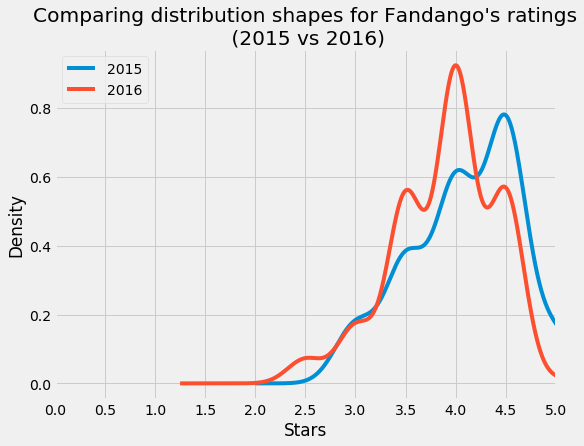

In [56]:
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label='2015', legend=True, figsize=(8, 6))
fandango_2016['fandango'].plot.kde(label='2016', legend=True)

plt.title("Comparing distribution shapes for Fandango's ratings\n (2015 vs 2016)")
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5.1,.5))
plt.show()

Two aspects are striking on the figure above:
- Both distributions are strongly left-skewed.
- The 2016 distribution is slightly shifted to the left relative to the 2015 distribution.

The slight left shift of the 2016 distribution is very interesting for our analysis. It shows that ratings were slightly lower in 2016 compared to 2015.

### Comparing Relative Frequencies

We want to examine the frequency tables of the two distributions to analyze some numbers. Let's normalize the tables and show percentages because the data sets have a different number of movies.

In [57]:
print('\x1b[1;1m'+'2015' ) #bold text
fandango_2015['Fandango_Stars'].value_counts(normalize=True).sort_index() * 100

2015


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [58]:
print('\x1b[1;1m'+'2016' ) #bold text
fandango_2016['fandango'].value_counts(normalize=True).sort_index() * 100

2016


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7.

The minimum rating is also lower in 2016 --2.5 instead of 3 stars in 2015.

For 3.5 and 4 stars, percentages went up in 2016.

### Determining the Direction of the Change

To get a more precise picture of the direction of the change, we'll take a couple of summary metrics.

In [59]:
mean_2015 = fandango_2015['Fandango_Stars'].mean()
mean_2016 = fandango_2016['fandango'].mean()

median_2015 = fandango_2015['Fandango_Stars'].median()
median_2016 = fandango_2016['fandango'].median()

mode_2015 = fandango_2015['Fandango_Stars'].mode()[0]
mode_2016 = fandango_2016['fandango'].mode()[0]

summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


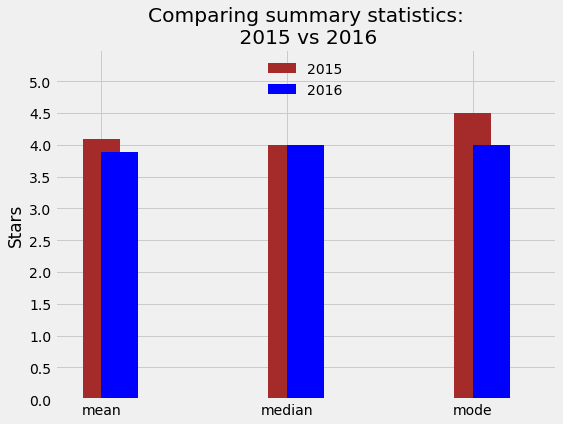

In [60]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(label='2015', align='center', color='brown', width=.2)
summary['2016'].plot.bar(label='2016', align='edge', color='blue', width=.2, figsize=(8,6), rot=0)

plt.title('Comparing summary statistics:\n 2015 vs 2016')
plt.ylim(0, 5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(loc='upper center', framealpha = 0)

plt.show()

The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.


In [61]:
(summary.loc['mean'][0] - summary.loc['mean'][1]) / summary.loc['mean'][0] * 100

4.842683568951993

### Conclusion

Our analysis showed that there is indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We can not be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.